## Data

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_recall_fscore_support, roc_auc_score

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset as HFDataset
import warnings
warnings.filterwarnings('ignore')


In [20]:
# !pip install -U datasets

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [22]:
# !ls


In [23]:
def load_and_explore_data(file_path):
    """
    Load the dataset and perform initial exploration
    Expected format: CSV with columns 'sentence' and 'label'
    Labels should be: 'support', 'refute', 'not enough information'
    """

    # Load the dataset
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print("\nFirst few rows:")
    print(df.head())

    # Check for missing values
    print(f"\nMissing values:\n{df.isnull().sum()}")

    # Analyze class distribution
    class_counts = df['claims_labels'].value_counts()
    print(f"\nClass distribution:")
    print(class_counts)
    print(f"\nClass proportions:")
    print(df['claims_labels'].value_counts(normalize=True))

    # Visualize class distribution
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    class_counts.plot(kind='bar')
    plt.title('Class Distribution (Count)')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    df['claims_labels'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
    plt.title('Class Distribution (Percentage)')

    plt.tight_layout()
    plt.show()

    # Text length analysis
    df['text_length'] = df['claims'].str.len()
    df['word_count'] = df['claims'].str.split().str.len()

    print(f"\nText statistics:")
    print(df[['text_length', 'word_count']].describe())

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    df['text_length'].hist(bins=50, alpha=0.7)
    plt.title('Distribution of Text Length (characters)')
    plt.xlabel('Character count')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    df['word_count'].hist(bins=50, alpha=0.7)
    plt.title('Distribution of Word Count')
    plt.xlabel('Word count')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return df

In [24]:
def check_class_imbalance(df, threshold=0.6):
    """
    Check if dataset has significant class imbalance
    """
    class_proportions = df['claims_labels'].value_counts(normalize=True)
    max_proportion = class_proportions.max()

    print(f"Maximum class proportion: {max_proportion:.3f}")

    if max_proportion > threshold:
        print(f"⚠️  Class imbalance detected! Majority class has {max_proportion:.1%} of samples")
        return True
    else:
        print("✅ Classes are relatively balanced")
        return False

In [25]:
# data_file_path = 'cleaned_data_no_special_characters.csv'

In [26]:
# df = load_and_explore_data(data_file_path)

In [27]:
# from datasets import load_dataset
# import pandas as pd

# # 1. Load the dataset
# dataset = load_dataset("amandakonet/climate_fever_adopted")

# # 2. Convert to pandas DataFrames and keep only required columns
# train_df = pd.DataFrame(dataset['train'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})
# val_df = pd.DataFrame(dataset['valid'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})
# test_df = pd.DataFrame(dataset['test'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})

In [28]:
# from datasets import load_dataset
# import pandas as pd

# # 1. Load the datasetJasontth/climate_fever_plus
# dataset = load_dataset("Jasontth/climate_fever_plus")

# # 2. Convert to pandas DataFrames and keep only required columns
# train_df = pd.DataFrame(dataset['train'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})
# val_df = pd.DataFrame(dataset['valid'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})
# test_df = pd.DataFrame(dataset['test'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})

In [29]:
# import pandas as pd

# # Load all three datasets
# train_df = pd.read_csv('/content/train_processed.csv', usecols=['claims', 'claims_labels'])


# print(f"Train: {train_df.shape}")
# print(f"Test: {test_df.shape}")
# print(f"Validation: {val_df.shape}")

In [30]:
# # Define label to remove
# label_to_remove = "NOT_ENOUGH_INFO"

# # Filter out that label from each DataFrame
# train_df = train_df[train_df["claims_labels"] != label_to_remove].reset_index(drop=True)
# val_df = val_df[val_df["claims_labels"] != label_to_remove].reset_index(drop=True)
# test_df = test_df[test_df["claims_labels"] != label_to_remove].reset_index(drop=True)

# # Confirm updated class distributions
# print("✅ Train class distribution:")
# print(train_df["claims_labels"].value_counts())

# print("\n✅ Validation class distribution:")
# print(val_df["claims_labels"].value_counts())

# print("\n✅ Test class distribution:")
# print(test_df["claims_labels"].value_counts())


In [31]:
# train_df.to_csv("filtered_train_2.csv", index=False)

In [32]:
def calculate_class_weights(train_labels):
    """
    Calculate class weights for weighted cross-entropy loss
    """
    from collections import Counter

    # Map labels to numerical format
    label_map = {'REFUTES': 0, 'SUPPORTS': 1} # Ensure this matches the dataset mapping
    numerical_labels = [label_map[label] for label in train_labels]

    # Count occurrences of each class
    class_counts = Counter(numerical_labels)
    total_samples = len(numerical_labels)

    # Calculate weights (inverse frequency)
    # Ensure weights are calculated and returned in the order of numerical labels (0, 1)
    weight_list = [0] * len(label_map)
    for class_id, count in class_counts.items():
        weight_list[class_id] = total_samples / (len(class_counts) * count)

    print(f"Class distribution: {class_counts}")
    print(f"Class weights (ordered by label ID): {weight_list}")

    return weight_list

In [33]:
# import pandas as pd
# import json

# # Load JSONL into a DataFrame
# dataset_path = "climate-fever-dataset-r1.jsonl"  # replace with your file path
# records = [json.loads(line) for line in open(dataset_path, 'r', encoding='utf-8')]

# # Convert to DataFrame (only top-level claim fields)
# df = pd.DataFrame([{
#     "claim": rec["claim"],
#     "claim_label": rec["claim_label"]
# } for rec in records])

# # Example: remove a label
# label_to_remove = "NOT_ENOUGH_INFO"
# df = df[df["claim_label"] != label_to_remove].reset_index(drop=True)

# # Save as CSV
# df.to_csv("climate_fever_filtered.csv", index=False)

# print(f"Saved {len(df)} rows to climate_fever_filtered.csv")


In [34]:
# import pandas as pd
# import json

# # Load JSONL into a DataFrame
# dataset_path = "climate-fever-dataset-r1.jsonl"  # replace with your file path
# records = [json.loads(line) for line in open(dataset_path, 'r', encoding='utf-8')]

# # Convert to DataFrame (only top-level claim fields)
# df = pd.DataFrame([{
#     "claim": rec["claim"],
#     "claim_label": rec["claim_label"]
# } for rec in records])

# # Keep only SUPPORTS or REFUTES claims
# df = df[df["claim_label"].isin(["SUPPORTS", "REFUTES"])].reset_index(drop=True)

# # Save as CSV
# df.to_csv("climate_fever_filtered_supports_refutes.csv", index=False)

# print(f"Saved {len(df)} rows with SUPPORTS or REFUTES to climate_fever_filtered_supports_refutes.csv")


In [35]:
# import pandas as pd
# import numpy as np
# from collections import Counter
# import os

# def analyze_dataset_duplicates(csv_file_path, text_column='claims', label_column='claims_labels'):
#     """
#     Comprehensive duplicate analysis for climate dataset

#     Args:
#         csv_file_path (str): Path to your CSV file
#         text_column (str): Name of the text column (default: 'claims')
#         label_column (str): Name of the label column (default: 'claims_labels')
#     """

#     print("🔍 ANALYZING DATASET FOR DUPLICATES")
#     print("=" * 60)

#     # Load the dataset
#     try:
#         df = pd.read_csv(csv_file_path)
#         print(f"✅ Loaded dataset: {csv_file_path}")
#         print(f"📊 Original dataset shape: {df.shape}")
#     except FileNotFoundError:
#         print(f"❌ File not found: {csv_file_path}")
#         return None
#     except Exception as e:
#         print(f"❌ Error loading file: {e}")
#         return None

#     # Check if required columns exist
#     if text_column not in df.columns:
#         print(f"❌ Column '{text_column}' not found. Available columns: {df.columns.tolist()}")
#         return None

#     if label_column not in df.columns:
#         print(f"❌ Column '{label_column}' not found. Available columns: {df.columns.tolist()}")
#         return None

#     print(f"✅ Using columns: '{text_column}' and '{label_column}'")
#     print()

#     # Basic dataset info
#     print("📋 DATASET OVERVIEW")
#     print("-" * 30)
#     print(f"Total samples: {len(df)}")

#     # Label distribution
#     label_counts = df[label_column].value_counts()
#     print(f"Label distribution:")
#     for label, count in label_counts.items():
#         percentage = (count / len(df)) * 100
#         print(f"  {label}: {count} ({percentage:.1f}%)")
#     print()

#     # Check for missing values
#     missing_text = df[text_column].isnull().sum()
#     missing_labels = df[label_column].isnull().sum()
#     empty_text = (df[text_column].astype(str).str.strip() == '').sum()

#     print("🔍 MISSING/EMPTY DATA CHECK")
#     print("-" * 30)
#     print(f"Missing text values: {missing_text}")
#     print(f"Missing label values: {missing_labels}")
#     print(f"Empty text strings: {empty_text}")
#     print()

#     # Exact duplicate analysis
#     print("🔍 EXACT DUPLICATE ANALYSIS")
#     print("-" * 30)

#     # Check for exact duplicates in text
#     exact_duplicates = df.duplicated(subset=[text_column], keep=False)
#     exact_duplicate_count = exact_duplicates.sum()

#     print(f"Exact text duplicates: {exact_duplicate_count}")

#     if exact_duplicate_count > 0:
#         print("\n📋 EXACT DUPLICATE EXAMPLES:")
#         duplicate_texts = df[exact_duplicates].groupby(text_column)[label_column].apply(list).reset_index()

#         for idx, row in duplicate_texts.head(10).iterrows():  # Show first 10
#             text = row[text_column]
#             labels = row[label_column]
#             print(f"  Text: \"{text[:80]}{'...' if len(text) > 80 else ''}\"")
#             print(f"  Labels: {labels}")
#             print(f"  Count: {len(labels)}")
#             print()

#     # Check for conflicting labels (same text, different labels)
#     print("⚠️  CONFLICTING LABELS CHECK")
#     print("-" * 30)

#     text_label_groups = df.groupby(text_column)[label_column].nunique()
#     conflicting_texts = text_label_groups[text_label_groups > 1]

#     if len(conflicting_texts) > 0:
#         print(f"❌ Found {len(conflicting_texts)} texts with conflicting labels!")
#         print("\n📋 CONFLICTING EXAMPLES:")

#         for text in conflicting_texts.head(5).index:  # Show first 5
#             labels = df[df[text_column] == text][label_column].unique()
#             print(f"  Text: \"{text[:80]}{'...' if len(text) > 80 else ''}\"")
#             print(f"  Labels: {labels}")
#             print()
#     else:
#         print("✅ No conflicting labels found - each text has consistent labeling")

#     print()

#     # Near-duplicate analysis (similar texts)
#     print("🔍 NEAR-DUPLICATE ANALYSIS")
#     print("-" * 30)

#     # Check for very similar texts (same first 50 characters)
#     df['text_prefix'] = df[text_column].astype(str).str[:50].str.lower().str.strip()
#     near_duplicates = df.duplicated(subset=['text_prefix'], keep=False)
#     near_duplicate_count = near_duplicates.sum()

#     print(f"Near-duplicates (similar first 50 chars): {near_duplicate_count}")

#     if near_duplicate_count > 0:
#         print("\n📋 NEAR-DUPLICATE EXAMPLES:")
#         near_duplicate_groups = df[near_duplicates].groupby('text_prefix')[text_column].apply(list).reset_index()

#         for idx, row in near_duplicate_groups.head(5).iterrows():  # Show first 5
#             similar_texts = row[text_column]
#             print(f"  Similar group {idx + 1}:")
#             for text in similar_texts[:3]:  # Show first 3 in group
#                 print(f"    - \"{text[:80]}{'...' if len(text) > 80 else ''}\"")
#             if len(similar_texts) > 3:
#                 print(f"    ... and {len(similar_texts) - 3} more")
#             print()

#     # Clean the temporary column
#     df = df.drop('text_prefix', axis=1)

#     return df

# def remove_duplicates(df, text_column='claims', label_column='claims_labels', strategy='keep_first'):
#     """
#     Remove duplicates from the dataset

#     Args:
#         df (pd.DataFrame): The dataset
#         text_column (str): Name of the text column
#         label_column (str): Name of the label column
#         strategy (str): 'keep_first', 'keep_last', or 'remove_all'

#     Returns:
#         pd.DataFrame: Cleaned dataset
#     """

#     print("🧹 REMOVING DUPLICATES")
#     print("=" * 30)

#     original_size = len(df)

#     # Handle conflicting labels first
#     text_label_groups = df.groupby(text_column)[label_column].nunique()
#     conflicting_texts = text_label_groups[text_label_groups > 1]

#     if len(conflicting_texts) > 0:
#         print(f"⚠️  Found {len(conflicting_texts)} texts with conflicting labels")
#         print("🔧 Resolving conflicts by keeping the most frequent label...")

#         for text in conflicting_texts.index:
#             # Keep the most frequent label for this text
#             text_rows = df[df[text_column] == text]
#             most_frequent_label = text_rows[label_column].mode().iloc[0]

#             # Remove all instances of this text
#             df = df[df[text_column] != text]

#             # Add back one instance with the most frequent label
#             new_row = text_rows.iloc[0].copy()
#             new_row[label_column] = most_frequent_label
#             df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

#     # Remove exact duplicates
#     if strategy == 'keep_first':
#         keep = 'first'
#     elif strategy == 'keep_last':
#         keep = 'last'
#     elif strategy == 'remove_all':
#         # Remove all duplicates (keep none)
#         duplicated_mask = df.duplicated(subset=[text_column], keep=False)
#         df = df[~duplicated_mask]
#         keep = None
#     else:
#         keep = 'first'

#     if keep is not None:
#         df_clean = df.drop_duplicates(subset=[text_column], keep=keep)
#     else:
#         df_clean = df

#     removed_count = original_size - len(df_clean)

#     print(f"✅ Removed {removed_count} duplicate samples")
#     print(f"📊 Dataset size: {original_size} → {len(df_clean)}")

#     # Show new label distribution
#     label_counts = df_clean[label_column].value_counts()
#     print(f"\n📊 New label distribution:")
#     for label, count in label_counts.items():
#         percentage = (count / len(df_clean)) * 100
#         print(f"  {label}: {count} ({percentage:.1f}%)")

#     return df_clean

# def process_dataset(csv_file_path, output_path=None, text_column='claims', label_column='claims_labels'):
#     """
#     Complete pipeline to analyze and clean dataset
#     """

#     # Analyze duplicates
#     df = analyze_dataset_duplicates(csv_file_path, text_column, label_column)

#     if df is None:
#         return

#     # Ask user what to do
#     print("\n🤔 WHAT WOULD YOU LIKE TO DO?")
#     print("1. Remove exact duplicates (keep first occurrence)")
#     print("2. Remove exact duplicates (keep last occurrence)")
#     print("3. Remove ALL duplicates (keep none)")
#     print("4. Keep dataset as-is (no changes)")

#     try:
#         choice = input("\nEnter your choice (1-4): ").strip()
#     except:
#         choice = "1"  # Default choice

#     if choice == "1":
#         df_clean = remove_duplicates(df, text_column, label_column, 'keep_first')
#     elif choice == "2":
#         df_clean = remove_duplicates(df, text_column, label_column, 'keep_last')
#     elif choice == "3":
#         df_clean = remove_duplicates(df, text_column, label_column, 'remove_all')
#     elif choice == "4":
#         df_clean = df
#         print("✅ Keeping dataset unchanged")
#     else:
#         df_clean = remove_duplicates(df, text_column, label_column, 'keep_first')
#         print("Invalid choice, defaulting to option 1")

#     # Save cleaned dataset
#     if output_path is None:
#         base_name = os.path.splitext(csv_file_path)[0]
#         output_path = f"{base_name}_cleaned.csv"

#     df_clean.to_csv(output_path, index=False)
#     print(f"\n💾 Cleaned dataset saved to: {output_path}")

#     return df_clean

# # Example usage
# if __name__ == "__main__":
#     # Replace with your actual CSV file path
#     csv_files_to_check = [
#         "train_processed.csv",
#     ]

#     print("🌍 CLIMATE DATASET DUPLICATE CHECKER")
#     print("=" * 60)

#     for csv_file in csv_files_to_check:
#         if os.path.exists(csv_file):
#             print(f"\n🔍 Checking: {csv_file}")
#             print("=" * 40)

#             # Just analyze (don't clean automatically)
#             df = analyze_dataset_duplicates(csv_file)

#             if df is not None:
#                 print(f"✅ Analysis complete for {csv_file}")
#             print("\n" + "="*60 + "\n")
#         else:
#             print(f"⏭️  Skipping {csv_file} (file not found)")

#     print("🎯 SUMMARY:")
#     print("- Run process_dataset('your_file.csv') to clean a specific file")
#     print("- The script will show you duplicates and let you choose how to handle them")
#     print("- Cleaned files will be saved with '_cleaned' suffix")

In [36]:
import pandas as pd

# Replace with your CSV file path
csv_path = "Data_version5_final_augmented.csv"

# Load CSV into DataFrame
df = pd.read_csv(csv_path)

# Keep only 'claim' and 'claim_label' columns
df = df[['claims', 'claims_labels']]

# Now you can work with the filtered DataFrame
print(df.head())  # prints first 5 rows


                                              claims claims_labels
0  global warming is driving polar bears toward e...      SUPPORTS
1  the sun has gone into ‘lockdown’ which could c...      SUPPORTS
2        the polar bear population has been growing.       REFUTES
3  ironic' study finds more co2 has slightly cool...       REFUTES
4  human additions of co2 are in the margin of er...       REFUTES


In [37]:
def create_train_val_test_split(df, train_size=0.8, val_size=0.10, test_size=0.10, random_state=42):
    """
    Create stratified train/validation/test splits
    """

    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Split sizes must sum to 1.0"

    # First split: train and temp (val + test)
    train_df, temp_df = train_test_split(
        df,
        train_size=train_size,
        stratify=df['claims_labels'],
        random_state=random_state
    )

    # Second split: validation and test from temp
    val_ratio = val_size / (val_size + test_size)
    val_df, test_df = train_test_split(
        temp_df,
        train_size=val_ratio,
        stratify=temp_df['claims_labels'],
        random_state=random_state
    )

    print("Data split summary:")
    print(f"Train: {len(train_df)} samples ({len(train_df)/len(df):.1%})")
    print(f"Validation: {len(val_df)} samples ({len(val_df)/len(df):.1%})")
    print(f"Test: {len(test_df)} samples ({len(test_df)/len(df):.1%})")

    # Check class distribution in each split
    print(f"\nClass distribution in splits:")
    for split_name, split_df in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
        print(f"\n{split_name}:")
        print(split_df['claims_labels'].value_counts())

    return train_df, val_df, test_df

In [38]:
train_df, val_df, test_df = create_train_val_test_split(df)

Data split summary:
Train: 3260 samples (80.0%)
Validation: 407 samples (10.0%)
Test: 408 samples (10.0%)

Class distribution in splits:

Train:
claims_labels
SUPPORTS    1719
REFUTES     1541
Name: count, dtype: int64

Validation:
claims_labels
SUPPORTS    215
REFUTES     192
Name: count, dtype: int64

Test:
claims_labels
SUPPORTS    215
REFUTES     193
Name: count, dtype: int64


In [39]:
 # Calculate class weights from training data
# The label_map in calculate_class_weights should match the label_map in ClimateClaimDataset
class_weights = calculate_class_weights(train_df['claims_labels'])

Class distribution: Counter({1: 1719, 0: 1541})
Class weights (ordered by label ID): [1.0577547047371836, 0.9482257126236184]


## DATASET CLASS FOR PYTORCH

In [40]:

class ClimateClaimDataset(Dataset):
    def __init__(self, claims, labels, tokenizer, max_length=256):
        self.claims = claims
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Create label mapping
        unique_labels = sorted(list(set(labels)))
        self.label2id = {label: i for i, label in enumerate(unique_labels)}
        self.id2label = {i: label for label, i in self.label2id.items()}

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, idx):
        claim = str(self.claims[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            claim,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.label2id[label], dtype=torch.long)
        }


## MODEL SETUP AND TRAINING

In [41]:
# import torch
# import torch.nn as nn
# from transformers import AutoModel, AutoConfig

# class ClimateBERTWithFFHead(nn.Module):
#     def __init__(self, model_name, num_labels=2, dropout_rate=0.3, class_weights=None):
#         super().__init__()

#         self.config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
#         self.base_model = AutoModel.from_pretrained(model_name, config=self.config)

#         self.class_weights = class_weights  # store weights if provided

#         hidden_size = self.config.hidden_size

#         self.classifier = nn.Sequential(
#             nn.Linear(hidden_size, hidden_size),
#             nn.Tanh(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(hidden_size, num_labels)
#         )

#     def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
#         outputs = self.base_model(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             return_dict=True,
#         )

#         pooled_output = outputs.last_hidden_state[:, 0]  # CLS token
#         logits = self.classifier(pooled_output)

#         loss = None
#         if labels is not None:
#             if self.class_weights is not None:
#                 # Ensure class weights are a tensor and on the correct device
#                 weight_tensor = torch.tensor(
#                     self.class_weights, dtype=torch.float32, device=logits.device
#                 )
#                 loss_fct = nn.CrossEntropyLoss(weight=weight_tensor)
#             else:
#                 loss_fct = nn.CrossEntropyLoss()

#             loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

#         return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

In [42]:
class WeightedTrainer(Trainer):
    """
    Custom trainer with class weights and label smoothing for handling imbalanced datasets
    """
    def __init__(self, class_weights=None, label_smoothing=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.label_smoothing = label_smoothing

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Compute weighted loss with label smoothing
        if self.class_weights is not None:
            # Convert class weights to tensor
            weight_tensor = torch.tensor(
                [self.class_weights[i] for i in range(len(self.class_weights))],
                dtype=torch.float32,
                device=labels.device
            )
            loss_fct = torch.nn.CrossEntropyLoss(
                weight=weight_tensor,
                label_smoothing=self.label_smoothing
            )
        else:
            # Standard loss with label smoothing
            loss_fct = torch.nn.CrossEntropyLoss(label_smoothing=self.label_smoothing)

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

def setup_model_and_tokenizer(model_name="climatebert/distilroberta-base-climate-f", num_labels=2, class_weights=None):
    """
    Setup ClimateBERT model with dropout=0.3 and optional class weights
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Load model with custom dropout
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        attention_probs_dropout_prob=0.3,    # Set attention dropout
        hidden_dropout_prob=0.3,             # Set hidden dropout
        classifier_dropout=0.3                # Set classifier dropout
    )

    return model, tokenizer

def create_datasets(train_df, val_df, test_df, tokenizer, max_length=256):
    """
    Create dataset objects for training
    """
    train_dataset = ClimateClaimDataset(
        train_df['claims'].tolist(),
        train_df['claims_labels'].tolist(),
        tokenizer,
        max_length
    )

    val_dataset = ClimateClaimDataset(
        val_df['claims'].tolist(),
        val_df['claims_labels'].tolist(),
        tokenizer,
        max_length
    )

    test_dataset = ClimateClaimDataset(
        test_df['claims'].tolist(),
        test_df['claims_labels'].tolist(),
        tokenizer,
        max_length
    )

    return train_dataset, val_dataset, test_dataset



def compute_metrics(eval_pred):
    """
    Compute comprehensive evaluation metrics including AUC
    """
    import torch.nn.functional as F
    predictions, labels = eval_pred

    # Get predicted probabilities for AUC calculation
    probs = F.softmax(torch.tensor(predictions), dim=-1).numpy()
    predicted_labels = np.argmax(predictions, axis=1)

    # Overall accuracy
    accuracy = accuracy_score(labels, predicted_labels)

    # Class-wise metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predicted_labels, average=None, zero_division=0
    )

    # Macro and weighted averages
    f1_macro = f1_score(labels, predicted_labels, average='macro', zero_division=0)
    f1_weighted = f1_score(labels, predicted_labels, average='weighted', zero_division=0)

    # AUC calculation (for binary classification)
    try:
        if len(np.unique(labels)) == 2:  # Binary classification
            auc = roc_auc_score(labels, probs[:, 1])  # Use probability of positive class
        else:
            auc = roc_auc_score(labels, probs, multi_class='ovr', average='macro')
    except ValueError:
        auc = 0.0  # Fallback if AUC can't be calculated


    class_labels = {'REFUTES': 0, 'SUPPORTS': 1} # Ensure this matches the label_map used elsewhere

    # Metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'auc': auc
    }

    # Add class-specific metrics with label names
    for i in range(len(f1)):
        # Get label name from the class_labels dictionary
        label_name = class_labels.get(i, f'class_{i}')
        metrics[f'f1_{label_name}'] = f1[i]
        metrics[f'precision_{label_name}'] = precision[i]
        metrics[f'recall_{label_name}'] = recall[i]


    return metrics


def train_model(model, train_dataset, val_dataset, class_weights=None, output_dir="./climate-claim-classifier"):
    """
    Train the model following ClimateBERT paper hyperparameters
    """

    """
    Train the model with your specified configuration
    """

    # YOUR SPECIFIED CONFIGURATION
    training_args = TrainingArguments(
        output_dir=output_dir,

        # Training parameters
        num_train_epochs=10,                    # 10 epochs as specified
        per_device_train_batch_size=16,         # Batch size 16 as specified
        per_device_eval_batch_size=32,

        # Optimizer and learning rate
        learning_rate=2e-5,                     # Learning rate 2e-5 as specified
        weight_decay=0.01,                      # Weight decay for AdamW
        adam_beta1=0.9,                         # AdamW parameters
        adam_beta2=0.999,
        adam_epsilon=1e-8,

        # Learning rate scheduling
        warmup_ratio=0.1,                       # Warm-up for better training
        lr_scheduler_type="linear",

        # Evaluation and saving
        eval_strategy="epoch",                  # Evaluate every epoch
        save_strategy="epoch",                  # Save every epoch
        load_best_model_at_end=True,           # Load best model based on metric
        metric_for_best_model="f1_macro",# Use F1-score for early stopping
        greater_is_better=True,
        save_total_limit=3,                     # Keep only 3 best models

        # Early stopping will be handled by callback

        # Logging
        logging_dir='./logs',
        logging_steps=50,
        logging_strategy="steps",

        # Other configurations
        seed=42,
        dataloader_drop_last=False,
        push_to_hub=False,
        fp16=torch.cuda.is_available(),         # Use FP16 if CUDA available
        dataloader_pin_memory=True,
        remove_unused_columns=True,
        report_to=None,                         # Disable wandb/tensorboard
        max_grad_norm=1.0,                      # Gradient clipping
        dataloader_num_workers=2,
    )

    # Create trainer with specified configurations
    trainer = WeightedTrainer(
        class_weights=class_weights,            # Weighted Cross-Entropy
        label_smoothing=0.1,                   # Label smoothing 0.1
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,        # Precision, Recall, F1, AUC
        callbacks=[
            EarlyStoppingCallback(
                early_stopping_patience=2,     # Early stopping based on validation F1
                early_stopping_threshold=0.001
            )
        ]
    )

    print("=" * 60)
    print(f"🔧 Early Stopping: Based on Validation F1-score")
    print(f"🔧 Evaluation Metrics: Precision, Recall, F1-score, AUC")
    print(f"🔧 Class Weights: {class_weights}")
    print("=" * 60)

    print("Starting training...")
    trainer.train()
    trainer.save_model()

    return trainer

In [43]:

def stratified_cross_validation(df, model_name="climatebert/distilroberta-base-climate-f",
                               n_splits=5, max_length=256):
    """
    Perform 5-fold stratified cross-validation as specified
    """
    print("=" * 60)
    print("PERFORMING 5-FOLD STRATIFIED CROSS-VALIDATION")
    print("=" * 60)

    # Prepare data
    texts = df['claims'].tolist()
    labels = df['claims_labels'].tolist()

    # Convert labels to numerical format
    label_map = {'REFUTES': 0, 'SUPPORTS': 1}
    numerical_labels = [label_map[label] for label in labels]

    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Store results
    cv_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, numerical_labels)):
        print(f"\n🔄 FOLD {fold + 1}/{n_splits}")
        print("-" * 40)

        # Split data
        train_texts = [texts[i] for i in train_idx]
        train_labels = [numerical_labels[i] for i in train_idx]
        val_texts = [texts[i] for i in val_idx]
        val_labels = [numerical_labels[i] for i in val_idx]

        # Calculate class weights for this fold
        class_weights = calculate_class_weights(train_labels)

        # Setup model and tokenizer
        model, tokenizer = setup_model_and_tokenizer(
            model_name=model_name,
            num_labels=2,
            class_weights=class_weights
        )

        # Create datasets
        train_dataset = ClimateClaimDataset(train_texts, train_labels, tokenizer, max_length)
        val_dataset = ClimateClaimDataset(val_texts, val_labels, tokenizer, max_length)

        # Train model
        trainer = train_model_with_config(
            model=model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            class_weights=class_weights,
            output_dir=f"./cv_fold_{fold + 1}"
        )

        # Evaluate
        eval_results = trainer.evaluate()
        cv_results.append(eval_results)

        print(f"Fold {fold + 1} Results:")
        print(f"  Accuracy: {eval_results['eval_accuracy']:.4f}")
        print(f"  F1-Macro: {eval_results['eval_f1_macro']:.4f}")
        print(f"  AUC: {eval_results['eval_auc']:.4f}")

    # Calculate average results
    print("\n" + "=" * 60)
    print("CROSS-VALIDATION SUMMARY")
    print("=" * 60)

    avg_accuracy = np.mean([r['eval_accuracy'] for r in cv_results])
    avg_f1 = np.mean([r['eval_f1_macro'] for r in cv_results])
    avg_auc = np.mean([r['eval_auc'] for r in cv_results])

    std_accuracy = np.std([r['eval_accuracy'] for r in cv_results])
    std_f1 = np.std([r['eval_f1_macro'] for r in cv_results])
    std_auc = np.std([r['eval_auc'] for r in cv_results])

    print(f"📊 Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"📊 Average F1-Macro: {avg_f1:.4f} ± {std_f1:.4f}")
    print(f"📊 Average AUC: {avg_auc:.4f} ± {std_auc:.4f}")

    return cv_results

In [44]:

def evaluate_model(trainer, test_dataset, label_names):
    """
    Evaluate the trained model on test set with detailed class-wise metrics
    """
    from sklearn.metrics import classification_report, confusion_matrix, f1_score

    # Get predictions
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids

    # Calculate overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f"Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-score: {f1_macro:.4f}")
    print(f"Weighted F1-score: {f1_weighted:.4f}")

    # Detailed classification report
    print(f"\n Detailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

    # Class-wise F1 scores
    class_f1_scores = f1_score(y_true, y_pred, average=None)
    print(f"\nClass-wise F1-scores:")
    for i, (label, f1) in enumerate(zip(label_names, class_f1_scores)):
        print(f"  {label}: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Class-wise F1 scores visualization
    plt.figure(figsize=(10, 6))
    bars = plt.bar(label_names, class_f1_scores, color=['#ff9999', '#66b3ff', '#99ff99'])
    plt.title('Class-wise F1-scores')
    plt.ylabel('F1-score')
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar, score in zip(bars, class_f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return accuracy, f1_macro, y_pred, y_true

In [45]:
import matplotlib.pyplot as plt

def plot_training_history(trainer):
    """
    Plot training and validation metrics over time (for binary classes: support and refute only)
    """
    log_history = trainer.state.log_history

    # Extract training and evaluation metrics
    train_metrics = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
    eval_metrics = [log for log in log_history if 'eval_loss' in log]

    if not eval_metrics:
        print("No evaluation metrics found in training history.")
        return

    # Extract steps and metrics
    eval_steps = [log['step'] for log in eval_metrics]
    eval_accuracy = [log.get('eval_accuracy', 0) for log in eval_metrics]
    eval_f1_macro = [log.get('eval_f1_macro', 0) for log in eval_metrics]
    eval_f1_weighted = [log.get('eval_f1_weighted', 0) for log in eval_metrics]


    # Class-wise F1 scores (for only support and refute)
    eval_f1_support = [log.get('eval_f1_class_1', 0) for log in eval_metrics]
    eval_f1_refute = [log.get('eval_f1_class_0', 0) for log in eval_metrics]


    # Plot metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Overall metrics
    axes[0, 0].plot(eval_steps, eval_accuracy, 'b-o', label='Accuracy')
    axes[0, 0].plot(eval_steps, eval_f1_macro, 'r-o', label='Macro F1')
    axes[0, 0].plot(eval_steps, eval_f1_weighted, 'g-o', label='Weighted F1')
    axes[0, 0].set_title('Overall Validation Metrics')
    axes[0, 0].set_xlabel('Training Steps')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Class-wise F1 scores
    axes[0, 1].plot(eval_steps, eval_f1_support, 'b-o', label='Support F1')
    axes[0, 1].plot(eval_steps, eval_f1_refute, 'r-o', label='Refute F1')
    axes[0, 1].set_title('Class-wise F1 Scores')
    axes[0, 1].set_xlabel('Training Steps')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Training and validation loss
    train_steps = [log['step'] for log in train_metrics if 'loss' in log]
    train_loss = [log['loss'] for log in train_metrics if 'loss' in log]
    eval_loss = [log.get('eval_loss', 0) for log in eval_metrics]

    if train_steps and train_loss:
        axes[1, 0].plot(train_steps, train_loss, 'b-', label='Training Loss')
        axes[1, 0].plot(eval_steps, eval_loss, 'r-o', label='Validation Loss')
        axes[1, 0].set_title('Training and Validation Loss')
        axes[1, 0].set_xlabel('Training Steps')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

    # Learning rate schedule
    learning_rates = [log.get('learning_rate', 0) for log in train_metrics if 'learning_rate' in log]
    lr_steps = [log['step'] for log in train_metrics if 'learning_rate' in log]

    if lr_steps and learning_rates:
        axes[1, 1].plot(lr_steps, learning_rates, 'g-')
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].set_xlabel('Training Steps')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()


In [46]:
model, tokenizer = setup_model_and_tokenizer(num_labels=2,class_weights=class_weights)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
train_dataset, val_dataset, test_dataset = create_datasets(
        train_df, val_df, test_df, tokenizer
    )

In [48]:
train_dataset.label2id

{'REFUTES': 0, 'SUPPORTS': 1}

In [49]:
print(train_dataset.label2id)

{'REFUTES': 0, 'SUPPORTS': 1}


In [50]:
print(val_dataset.id2label)

{0: 'REFUTES', 1: 'SUPPORTS'}


In [51]:
trainer = train_model(model, train_dataset, val_dataset, class_weights=class_weights)

🔧 Early Stopping: Based on Validation F1-score
🔧 Evaluation Metrics: Precision, Recall, F1-score, AUC
🔧 Class Weights: [1.0577547047371836, 0.9482257126236184]
Starting training...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: imaanibrar86 (imaanibrar86-nust) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Auc,F1 Class 0,Precision Class 0,Recall Class 0,F1 Class 1,Precision Class 1,Recall Class 1
1,0.677300,0.649006,0.749386,0.740576,0.743278,0.841340,0.692771,0.821429,0.598958,0.788382,0.711610,0.883721
2,0.470200,0.458621,0.818182,0.814544,0.816012,0.921209,0.788571,0.873418,0.718750,0.840517,0.783133,0.906977
3,0.428800,0.427378,0.832924,0.832071,0.832747,0.938760,0.820106,0.833333,0.807292,0.844037,0.832579,0.855814
4,0.383400,0.437572,0.857494,0.856173,0.856952,0.938893,0.842391,0.880682,0.807292,0.869955,0.839827,0.902326
5,0.365200,0.469518,0.852580,0.850228,0.851289,0.942115,0.831461,0.902439,0.770833,0.868996,0.818930,0.925581
6,0.373900,0.437419,0.857494,0.856432,0.857130,0.945506,0.844086,0.872222,0.817708,0.868778,0.845815,0.893023


Test Results:
Accuracy: 0.8922
Macro F1-score: 0.8912
Weighted F1-score: 0.8918

 Detailed Classification Report:
              precision    recall  f1-score   support

     REFUTES     0.9209    0.8446    0.8811       193
    SUPPORTS     0.8701    0.9349    0.9013       215

    accuracy                         0.8922       408
   macro avg     0.8955    0.8897    0.8912       408
weighted avg     0.8941    0.8922    0.8918       408


Class-wise F1-scores:
  REFUTES: 0.8811
  SUPPORTS: 0.9013


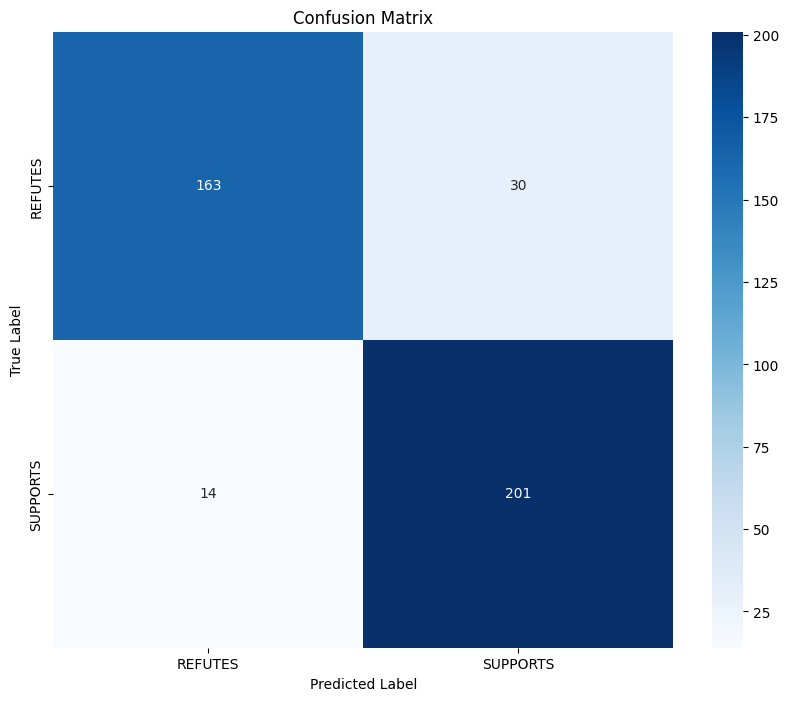

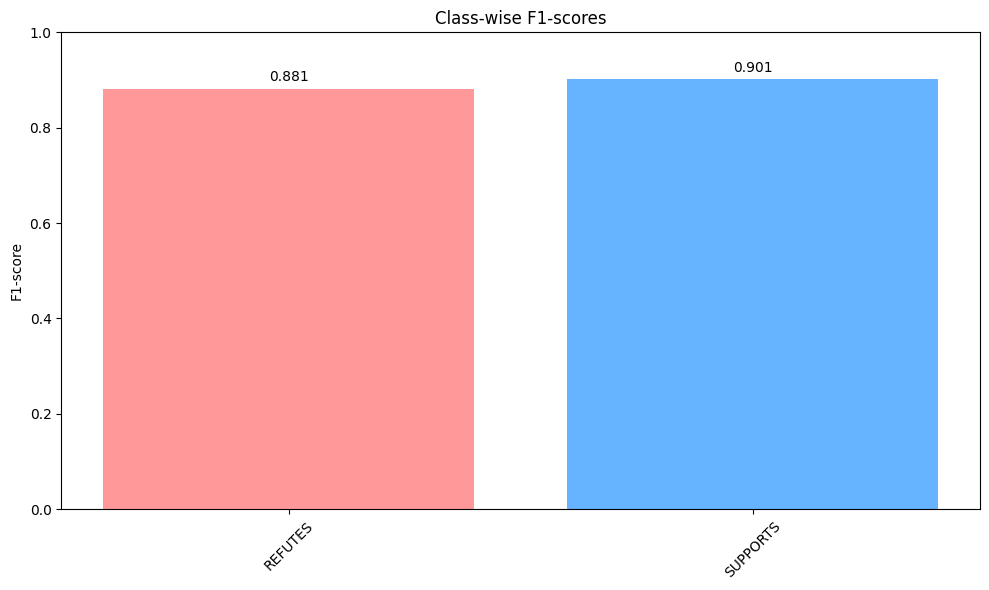

In [52]:

label_names = sorted(train_df['claims_labels'].unique())
accuracy, f1_macro, y_pred, y_true = evaluate_model(trainer, test_dataset, label_names)



In [53]:
from pprint import pprint
for log in trainer.state.log_history:
    if 'val_loss' in log:
        pprint(log)


In [54]:
print(f"\nPipeline completed!")
print(f"Final Results:")
print(f"   - Test accuracy: {accuracy:.4f}")
print(f"   - Macro F1-score: {f1_macro:.4f}")


Pipeline completed!
Final Results:
   - Test accuracy: 0.8922
   - Macro F1-score: 0.8912


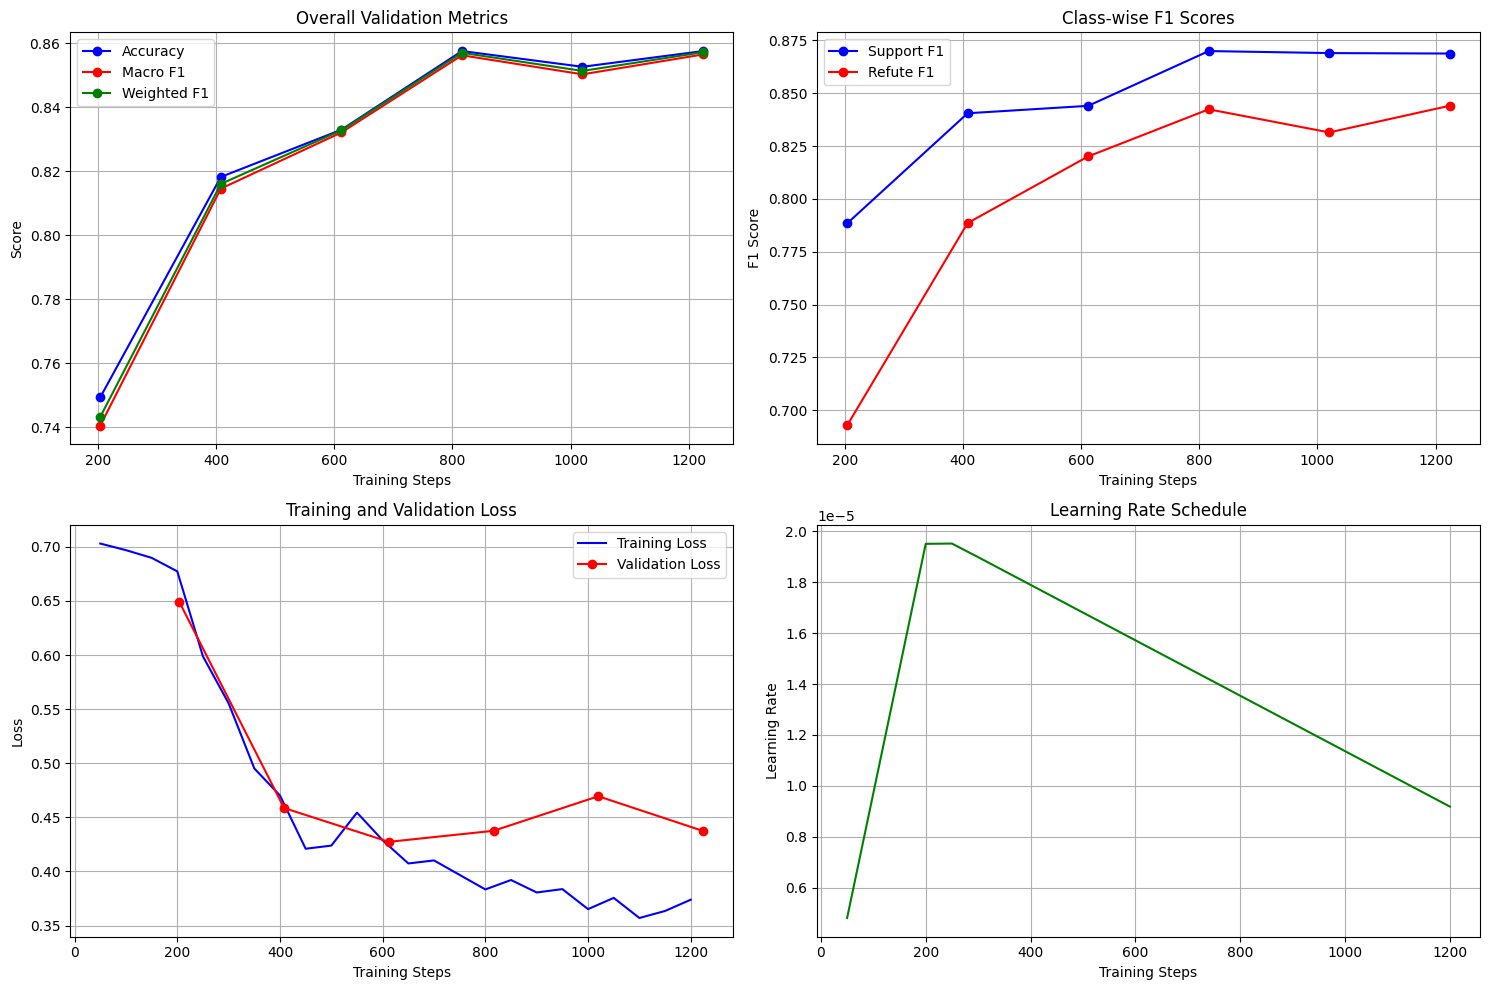

In [55]:
plot_training_history(trainer)

In [ ]:
Okay so now I want to do the section of implementation IV. IMPLEMENTATION

A. Model Architecture

B. Training Pipeline

C. Content Filtering Approach

- Threshold selection

D. Explainability Implementation

V. RESULTS

A. Model Performance

TABLE I

EVALUATION RESULTS FOR CLIMATEBERT

Class Precision Recall F1-Score Support

Support (0) 0.XX 0.XX 0.XX XX

Refute (1) 0.XX 0.XX 0.XX XX

Not Enough Info (2) 0.XX 0.XX 0.XX XX

Macro Avg 0.XX 0.XX 0.XX XX

Weighted Avg 0.XX 0.XX 0.XX XX

Accuracy 0.XX XX

- Error analysis and failure cases

B. Ablation Studies

C. Explainability Analysis

For my traing parmaters also, make a .  will share the details i used for training in form of code with you

Used this for train val and test split ( total datset was 4075)

def create_train_val_test_split(df, train_size=0.8, val_size=0.10, test_size=0.10, random_state=42):
    """
    Create stratified train/validation/test splits
    """

    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Split sizes must sum to 1.0"

    # First split: train and temp (val + test)
    train_df, temp_df = train_test_split(
        df,
        train_size=train_size,
        stratify=df['claims_labels'],
        random_state=random_state
    )

    # Second split: validation and test from temp
    val_ratio = val_size / (val_size + test_size)
    val_df, test_df = train_test_split(
        temp_df,
        train_size=val_ratio,
        stratify=temp_df['claims_labels'],
        random_state=random_state
    )

    print("Data split summary:")
    print(f"Train: {len(train_df)} samples ({len(train_df)/len(df):.1%})")
    print(f"Validation: {len(val_df)} samples ({len(val_df)/len(df):.1%})")
    print(f"Test: {len(test_df)} samples ({len(test_df)/len(df):.1%})")

    # Check class distribution in each split
    print(f"\nClass distribution in splits:")
    for split_name, split_df in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
        print(f"\n{split_name}:")
        print(split_df['claims_labels'].value_counts())

    return train_df, val_df, test_df

Train: claims_labels true 1719 flase 1541 Name: count, dtype: int64 Validation: claims_labels true  215 false 192 Name: count, dtype: int64 Test: claims_labels true 215 false 193 Name: count, dtype: int64

used class weights class_weights = calculate_class_weights(train_df['claims_labels'])

Class distribution: Counter({1: 1719, 0: 1541}) Class weights (ordered by label ID): [1.0577547047371836, 0.9482257126236184] where 0 is flase and 1 is true
class ClimateClaimDataset(Dataset):
    def __init__(self, claims, labels, tokenizer, max_length=256):
        self.claims = claims
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Create label mapping
        unique_labels = sorted(list(set(labels)))
        self.label2id = {label: i for i, label in enumerate(unique_labels)}
        self.id2label = {i: label for label, i in self.label2id.items()}

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, idx):
        claim = str(self.claims[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            claim,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.label2id[label], dtype=torch.long)
        }


 class ClimateClaimDataset(Dataset):     def __init__(self, claims, labels, tokenizer, max_length=256):         self.claims = claims         self.labels = labels         self.tokenizer = tokenizer         self.max_length = max_length          # Create label mapping         unique_labels = sorted(list(set(labels)))         self.label2id = {label: i for i, label in enumerate(unique_labels)}         self.id2label = {i: label for label, i in self.label2id.items()}      def __len__(self):         return len(self.claims)      def __getitem__(self, idx):         claim = str(self.claims[idx])         label = self.labels[idx]          # Tokenize         encoding = self.tokenizer(             claim,             add_special_tokens=True,             max_length=self.max_length,             padding='max_length',             truncation=True,             return_attention_mask=True,             return_tensors='pt'         )          return {             'input_ids': encoding['input_ids'].flatten(),             'attention_mask': encoding['attention_mask'].flatten(),             'labels': torch.tensor(self.label2id[label], dtype=torch.long)         } Other settings were 

in the pasted content:

now movinf to results 

[1224/2040 03:55 < 02:37, 5.18 it/s, Epoch 6/10]

EpochTraining LossValidation LossAccuracyF1 MacroF1 WeightedAucF1 Class 0Precision Class 0Recall Class 0F1 Class 1Precision Class 1Recall Class 110.6773000.6490060.7493860.7405760.7432780.8413400.6927710.8214290.5989580.7883820.7116100.88372120.4702000.4586210.8181820.8145440.8160120.9212090.7885710.8734180.7187500.8405170.7831330.90697730.4288000.4273780.8329240.8320710.8327470.9387600.8201060.8333330.8072920.8440370.8325790.85581440.3834000.4375720.8574940.8561730.8569520.9388930.8423910.8806820.8072920.8699550.8398270.90232650.3652000.4695180.8525800.8502280.8512890.9421150.8314610.9024390.7708330.8689960.8189300.92558160.3739000.4374190.8574940.8564320.8571300.9455060.8440860.8722220.8177080.8687780.8458150.893023

Test Results: Accuracy: 0.8922 Macro F1-score: 0.8912 Weighted F1-score: 0.8918 Detailed Classification Report: precision recall f1-score support REFUTES 0.9209 0.8446 0.8811 193 SUPPORTS 0.8701 0.9349 0.9013 215 accuracy 0.8922 408 macro avg 0.8955 0.8897 0.8912 408 weighted avg 0.8941 0.8922 0.8918 408 Class-wise F1-scores: REFUTES: 0.8811 SUPPORTS: 0.9013

We tried different hyperparameters combinations and then after research, different experiments with more techniques. This we're sharing the final technique. So you do kind of mention that there were experiments done and this results basically gave the best result. And then I will you can also share the link of the climate bird app which can be found on Hugging Face. And then just this was a whole the way the model was actually trained. And then I will share the code for content filtering and explainability. For content filtering, it's just like a prompt for Gemini. And for the explainability part, do tell that we tried SHAP as well and LIME as well. But the problem, explain SHAP like working and then just tell that it doesn't always give the best, the stable response. Why they don't always have the same results, do tell that as well. So because it's a transformer approach, so we tried the transformer interpret. It was stable and provide good insights on why the model. And then for explaining that to the users, we create simplified explanation of them also by Gemini. And I will share the explanation part code as well with you. And there was no particular reason for choosing Gemini here.You can tell that the reason for choosing Gemini was faster inference for the users. So Gemini 2.0 Flash was chosen based on its faster speed over other models that were there because their task wasn't exactly to work across the classifications. We made a trade-off between whether we want higher speed or over either we want that. So that was the reason for choosing 2.5 because it provides a perfect balance of logical reasoning with the speed..



In [71]:
import torch
import torch.nn.functional as F

def predict_claim(claim, model, tokenizer, label2id, max_length=256):
    """
    Predict the label and probability scores for a single claim
    """
    # Ensure model is in evaluation mode
    model.eval()

    # Tokenize the input claim
    encoding = tokenizer(
        claim,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Move tensors to the same device as the model
    input_ids = encoding['input_ids'].to(model.device)
    attention_mask = encoding['attention_mask'].to(model.device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Get probabilities
    probs = F.softmax(logits, dim=-1)[0] # Get probabilities for the single input

    # Get predicted label
    predicted_id = torch.argmax(probs).item()

    # Map predicted ID back to label name
    id2label = {v: k for k, v in label2id.items()}
    predicted_label = id2label[predicted_id]

    # Prepare results
    results = {
        'predicted_label': predicted_label,
        'probabilities': {}
    }

    # Add probability for each label
    for label, id in label2id.items():
        results['probabilities'][label] = probs[id].item()

    return results

# --- Example Usage ---

# Assuming 'model', 'tokenizer', and 'train_dataset.label2id' are available from previous cells

# Example sentence to predict on
new_claim = "cliamte change is a hoax"

# Get the label mapping from the training dataset object
label2id = train_dataset.label2id

# Make the prediction
prediction_results = predict_claim(new_claim, model, tokenizer, label2id)

# Print the results
print(f"Claim: \"{new_claim}\"")
print(f"Predicted Label: {prediction_results['predicted_label']}")
print(f"Probabilities:")
for label, prob in prediction_results['probabilities'].items():
    print(f"  {label}: {prob:.4f}")

Claim: "cliamte change is a hoax"
Predicted Label: REFUTES
Probabilities:
  REFUTES: 0.9798
  SUPPORTS: 0.0202


In [57]:
import torch
import torch.nn.functional as F

def predict_claim(claim, model, tokenizer, label2id, max_length=256):
    """
    Predict the label and probability scores for a single claim
    """
    # Ensure model is in evaluation mode
    model.eval()

    # Tokenize the input claim
    encoding = tokenizer(
        claim,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Move tensors to the same device as the model
    input_ids = encoding['input_ids'].to(model.device)
    attention_mask = encoding['attention_mask'].to(model.device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Get probabilities
    probs = F.softmax(logits, dim=-1)[0] # Get probabilities for the single input

    # Get predicted label
    predicted_id = torch.argmax(probs).item()

    # Map predicted ID back to label name
    id2label = {v: k for k, v in label2id.items()}
    predicted_label = id2label[predicted_id]

    # Get confidence (max probability)
    confidence = torch.max(probs).item()

    # Prepare results
    results = {
        'predicted_label': predicted_label,
        'confidence': confidence,
        'probabilities': {}
    }

    # Add probability for each label
    for label, id in label2id.items():
        results['probabilities'][label] = probs[id].item()

    return results

# ============================================================================
# COMPREHENSIVE TEST SUITE - BINARY CLASSIFICATION (SUPPORTS/REFUTES)
# ============================================================================

def run_comprehensive_test(model, tokenizer, label2id):
    """
    Test the model with diverse, challenging examples
    Shows predicted label, expected label, confidence score, and correctness
    """

    # Test cases with various styles and contexts
    test_cases = [
        # ═══════════════════════════════════════════════════════════════════
        # SOCIAL MEDIA STYLE CLAIMS (Casual, informal language)
        # ═══════════════════════════════════════════════════════════════════
        {
            'claim': "lol climate change is just weather patterns doing their thing naturally 🌡️",
            'expected': 'REFUTES',
            'category': 'Social Media - Casual Denial'
        },
        {
            'claim': "guys my city had snow in April so much for global warming 😂❄️",
            'expected': 'REFUTES',
            'category': 'Social Media - Weather Confusion'
        },
        {
            'claim': "omg the ocean is literally becoming acidic because of all the CO2 we're pumping out 😱",
            'expected': 'SUPPORTS',
            'category': 'Social Media - Ocean Acidification'
        },
        {
            'claim': "renewable energy is destroying the planet more than fossil fuels tbh",
            'expected': 'REFUTES',
            'category': 'Social Media - Renewable Myth'
        },

        # ═══════════════════════════════════════════════════════════════════
        # TECHNICAL/SCIENTIFIC STYLE (Formal, precise language)
        # ═══════════════════════════════════════════════════════════════════
        {
            'claim': "Anthropogenic CO₂ emissions have increased atmospheric concentrations from 280 ppm to over 420 ppm since 1850",
            'expected': 'SUPPORTS',
            'category': 'Technical - CO2 Concentrations'
        },
        {
            'claim': "Solar irradiance variations account for the majority of observed warming trends in the 21st century",
            'expected': 'REFUTES',
            'category': 'Technical - Solar Forcing Myth'
        },
        {
            'claim': "The albedo effect from melting Arctic ice creates a positive feedback loop that accelerates warming",
            'expected': 'SUPPORTS',
            'category': 'Technical - Albedo Feedback'
        },
        {
            'claim': "Climate sensitivity to CO2 doubling is only 0.5°C according to recent satellite measurements",
            'expected': 'REFUTES',
            'category': 'Technical - Low Sensitivity Claim'
        },

        # ═══════════════════════════════════════════════════════════════════
        # NEWS HEADLINE STYLE (Journalistic, attention-grabbing)
        # ═══════════════════════════════════════════════════════════════════
        {
            'claim': "BREAKING: Antarctic ice sheet gains massive amounts of ice, scientists baffled by climate models",
            'expected': 'REFUTES',
            'category': 'News - Misleading Antarctica'
        },
        {
            'claim': "New study confirms: Greenland ice loss has tripled since the 1990s",
            'expected': 'SUPPORTS',
            'category': 'News - Greenland Ice Loss'
        },
        {
            'claim': "Scientists admit global warming stopped in 1998 and hasn't resumed",
            'expected': 'REFUTES',
            'category': 'News - Hiatus Myth'
        },
        {
            'claim': "Record-breaking heat waves become 10 times more likely due to climate change",
            'expected': 'SUPPORTS',
            'category': 'News - Heat Wave Attribution'
        },

        # ═══════════════════════════════════════════════════════════════════
        # ECONOMIC/POLITICAL ANGLE (Focus on costs, policies)
        # ═══════════════════════════════════════════════════════════════════
        {
            'claim': "Climate policies will destroy the economy and cost millions of jobs without any environmental benefit",
            'expected': 'REFUTES',
            'category': 'Economic - Policy Scare Tactics'
        },
        {
            'claim': "The green energy transition is creating more jobs than it eliminates in fossil fuel industries",
            'expected': 'SUPPORTS',
            'category': 'Economic - Green Jobs'
        },
        {
            'claim': "Carbon taxes are just government money grabs that don't actually reduce emissions",
            'expected': 'REFUTES',
            'category': 'Economic - Carbon Tax Denial'
        },
        {
            'claim': "Extreme weather events cost the global economy over $100 billion annually",
            'expected': 'SUPPORTS',
            'category': 'Economic - Climate Damages'
        },

        # ═══════════════════════════════════════════════════════════════════
        # CONSPIRACY THEORY STYLE (Suspicious, alternative explanations)
        # ═══════════════════════════════════════════════════════════════════
        {
            'claim': "Climate scientists are hiding the real data because their funding depends on maintaining the global warming narrative",
            'expected': 'REFUTES',
            'category': 'Conspiracy - Scientist Funding'
        },
        {
            'claim': "The IPCC reports are written by politicians, not scientists, to push a global agenda",
            'expected': 'REFUTES',
            'category': 'Conspiracy - IPCC Authorship'
        },
        {
            'claim': "Temperature stations are deliberately placed in urban heat islands to inflate warming trends",
            'expected': 'REFUTES',
            'category': 'Conspiracy - Temperature Fraud'
        },
        {
            'claim': "Multiple independent temperature datasets from different organizations show consistent warming",
            'expected': 'SUPPORTS',
            'category': 'Fact Check - Temperature Consistency'
        },

        # ═══════════════════════════════════════════════════════════════════
        # RECENT EVENTS/MODERN CONTEXT (2023-2024 style claims)
        # ═══════════════════════════════════════════════════════════════════
        {
            'claim': "The 2023 global temperature records were only reached because of El Niño, not climate change",
            'expected': 'REFUTES',
            'category': 'Recent - 2023 Temperature Records'
        },
        {
            'claim': "AI data centers and cryptocurrency mining are significantly increasing global energy consumption",
            'expected': 'SUPPORTS',
            'category': 'Modern Tech - Digital Emissions'
        },
        {
            'claim': "Electric vehicles produce more emissions than gas cars when you include battery manufacturing",
            'expected': 'REFUTES',
            'category': 'Modern Tech - EV Lifecycle Myth'
        },
        {
            'claim': "Wildfires in 2023 released record amounts of carbon into the atmosphere",
            'expected': 'SUPPORTS',
            'category': 'Recent - Wildfire Emissions'
        },

        # ═══════════════════════════════════════════════════════════════════
        # TRICKY/NUANCED CLAIMS (Testing edge cases)
        # ═══════════════════════════════════════════════════════════════════
        {
            'claim': "Some regions will actually get cooler as global warming disrupts ocean currents",
            'expected': 'SUPPORTS',
            'category': 'Nuanced - Regional Cooling'
        },
        {
            'claim': "CO2 is plant food so higher concentrations will solve world hunger",
            'expected': 'REFUTES',
            'category': 'Nuanced - CO2 Fertilization Myth'
        },
        {
            'claim': "Volcanic eruptions release more CO2 than all human activities combined",
            'expected': 'REFUTES',
            'category': 'Nuanced - Volcanic vs Human CO2'
        },
        {
            'claim': "Arctic warming is happening twice as fast as the global average",
            'expected': 'SUPPORTS',
            'category': 'Nuanced - Arctic Amplification'
        },

        # ═══════════════════════════════════════════════════════════════════
        # EXTREME WEATHER ATTRIBUTION (Specific events)
        # ═══════════════════════════════════════════════════════════════════
        {
            'claim': "Hurricane intensity is not increasing despite climate change predictions",
            'expected': 'REFUTES',
            'category': 'Weather - Hurricane Trends'
        },
        {
            'claim': "Drought frequency and severity are increasing in many regions due to rising temperatures",
            'expected': 'SUPPORTS',
            'category': 'Weather - Drought Attribution'
        },
        {
            'claim': "Individual weather events cannot be attributed to climate change",
            'expected': 'REFUTES',
            'category': 'Weather - Attribution Science'
        },
        {
            'claim': "Heat domes and atmospheric rivers are becoming more common due to jet stream changes",
            'expected': 'SUPPORTS',
            'category': 'Weather - Extreme Patterns'
        }
    ]

    print("🌍 CLIMATE MISINFORMATION DETECTION - MODEL TEST RESULTS")
    print("=" * 80)
    print(f"Testing {len(test_cases)} diverse claims across multiple categories\n")

    correct_predictions = 0
    total_predictions = len(test_cases)

    # Track performance by category
    category_stats = {}

    for i, test_case in enumerate(test_cases, 1):
        claim = test_case['claim']
        expected = test_case['expected']
        category = test_case['category']

        # Make prediction
        result = predict_claim(claim, model, tokenizer, label2id)
        predicted = result['predicted_label']
        confidence = result['confidence']

        # Check if correct
        is_correct = predicted == expected
        if is_correct:
            correct_predictions += 1

        # Track category performance
        if category not in category_stats:
            category_stats[category] = {'correct': 0, 'total': 0}
        category_stats[category]['total'] += 1
        if is_correct:
            category_stats[category]['correct'] += 1

        # Color coding for results
        status_icon = "✅" if is_correct else "❌"
        confidence_bar = "🔥" if confidence > 0.8 else "🟡" if confidence > 0.6 else "🔴"

        print(f"{status_icon} Test {i:2d} | {confidence_bar} Confidence: {confidence:.3f}")
        print(f"   Category: {category}")
        print(f"   Claim: \"{claim[:80]}{'...' if len(claim) > 80 else ''}\"")
        print(f"   Expected: {expected} | Predicted: {predicted}")

        # Show probability breakdown
        probs = result['probabilities']
        prob_str = " | ".join([f"{label}: {prob:.3f}" for label, prob in probs.items()])
        print(f"   Probabilities: {prob_str}")
        print()

    # Summary statistics
    accuracy = correct_predictions / total_predictions
    print("=" * 80)
    print(f"📊 OVERALL RESULTS:")
    print(f"   Accuracy: {correct_predictions}/{total_predictions} = {accuracy:.3f} ({accuracy*100:.1f}%)")
    print()

    # Category breakdown
    print(f"📈 PERFORMANCE BY CATEGORY:")
    for category, stats in category_stats.items():
        cat_accuracy = stats['correct'] / stats['total']
        print(f"   {category}: {stats['correct']}/{stats['total']} = {cat_accuracy:.3f} ({cat_accuracy*100:.1f}%)")

    print()

    # Confidence analysis
    high_conf_correct = sum(1 for i, test_case in enumerate(test_cases)
                           if predict_claim(test_case['claim'], model, tokenizer, label2id)['confidence'] > 0.8
                           and predict_claim(test_case['claim'], model, tokenizer, label2id)['predicted_label'] == test_case['expected'])

    high_conf_total = sum(1 for test_case in test_cases
                         if predict_claim(test_case['claim'], model, tokenizer, label2id)['confidence'] > 0.8)

    if high_conf_total > 0:
        high_conf_accuracy = high_conf_correct / high_conf_total
        print(f"🎯 HIGH CONFIDENCE PREDICTIONS (>0.8):")
        print(f"   Accuracy: {high_conf_correct}/{high_conf_total} = {high_conf_accuracy:.3f} ({high_conf_accuracy*100:.1f}%)")

    return {
        'overall_accuracy': accuracy,
        'category_stats': category_stats,
        'total_tests': total_predictions,
        'correct_predictions': correct_predictions
    }

# ============================================================================
# RUN THE TEST SUITE
# ============================================================================

# Assuming you have model, tokenizer, and label2id from your training
# Uncomment and run this line to test your model:

results = run_comprehensive_test(model, tokenizer, train_dataset.label2id)


🌍 CLIMATE MISINFORMATION DETECTION - MODEL TEST RESULTS
Testing 32 diverse claims across multiple categories

✅ Test  1 | 🔥 Confidence: 0.909
   Category: Social Media - Casual Denial
   Claim: "lol climate change is just weather patterns doing their thing naturally 🌡️"
   Expected: REFUTES | Predicted: REFUTES
   Probabilities: REFUTES: 0.909 | SUPPORTS: 0.091

✅ Test  2 | 🔥 Confidence: 0.845
   Category: Social Media - Weather Confusion
   Claim: "guys my city had snow in April so much for global warming 😂❄️"
   Expected: REFUTES | Predicted: REFUTES
   Probabilities: REFUTES: 0.845 | SUPPORTS: 0.155

✅ Test  3 | 🟡 Confidence: 0.779
   Category: Social Media - Ocean Acidification
   Claim: "omg the ocean is literally becoming acidic because of all the CO2 we're pumping ..."
   Expected: SUPPORTS | Predicted: SUPPORTS
   Probabilities: REFUTES: 0.221 | SUPPORTS: 0.779

✅ Test  4 | 🟡 Confidence: 0.718
   Category: Social Media - Renewable Myth
   Claim: "renewable energy is destroying 

In [58]:

# ============================================================================
# INDIVIDUAL TEST EXAMPLES (Run these one by one to see detailed results)
# ============================================================================

def test_individual_examples(model, tokenizer, label2id):
    """
    Test specific examples one by one for detailed analysis
    """

    # Individual test cases for detailed inspection
    individual_tests = [
        {
            'claim': "lol climate change is just weather patterns doing their thing naturally 🌡️",
            'expected': 'REFUTES',
            'note': 'Social media style casual climate denial'
        },
        {
            'claim': "Anthropogenic CO₂ emissions have increased atmospheric concentrations from 280 ppm to over 420 ppm since 1850",
            'expected': 'SUPPORTS',
            'note': 'Technical/scientific accurate statement'
        },
        {
            'claim': "The 2023 global temperature records were only reached because of El Niño, not climate change",
            'expected': 'REFUTES',
            'note': 'Recent event misattribution'
        },
        {
            'claim': "Electric vehicles produce more emissions than gas cars when you include battery manufacturing",
            'expected': 'REFUTES',
            'note': 'Modern technology lifecycle myth'
        },
        {
            'claim': "Some regions will actually get cooler as global warming disrupts ocean currents",
            'expected': 'SUPPORTS',
            'note': 'Counter-intuitive but scientifically accurate'
        }
    ]

    print("🔍 INDIVIDUAL TEST EXAMPLES")
    print("=" * 60)

    for i, test in enumerate(individual_tests, 1):
        print(f"\n📝 Example {i}: {test['note']}")
        print("-" * 40)

        result = predict_claim(test['claim'], model, tokenizer, label2id)

        print(f"Claim: \"{test['claim']}\"")
        print(f"Expected: {test['expected']}")
        print(f"Predicted: {result['predicted_label']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print(f"Correct: {'✅ YES' if result['predicted_label'] == test['expected'] else '❌ NO'}")
        print(f"Probabilities:")
        for label, prob in result['probabilities'].items():
            print(f"  {label}: {prob:.4f}")

# Uncomment to run individual tests:
test_individual_examples(model, tokenizer, train_dataset.label2id)

🔍 INDIVIDUAL TEST EXAMPLES

📝 Example 1: Social media style casual climate denial
----------------------------------------
Claim: "lol climate change is just weather patterns doing their thing naturally 🌡️"
Expected: REFUTES
Predicted: REFUTES
Confidence: 0.9087
Correct: ✅ YES
Probabilities:
  REFUTES: 0.9087
  SUPPORTS: 0.0913

📝 Example 2: Technical/scientific accurate statement
----------------------------------------
Claim: "Anthropogenic CO₂ emissions have increased atmospheric concentrations from 280 ppm to over 420 ppm since 1850"
Expected: SUPPORTS
Predicted: SUPPORTS
Confidence: 0.9092
Correct: ✅ YES
Probabilities:
  REFUTES: 0.0908
  SUPPORTS: 0.9092

📝 Example 3: Recent event misattribution
----------------------------------------
Claim: "The 2023 global temperature records were only reached because of El Niño, not climate change"
Expected: REFUTES
Predicted: REFUTES
Confidence: 0.9244
Correct: ✅ YES
Probabilities:
  REFUTES: 0.9244
  SUPPORTS: 0.0756

📝 Example 4: Modern te

In [65]:
trainer.save_model("./final_model_augv2_89")
tokenizer.save_pretrained("./final_model_augv2_89")
model.config.save_pretrained("./final_model_augv2_89")

In [66]:
import shutil

shutil.make_archive("/content/final_model_augv2_89", 'zip', "./final_model_augv2_89")


'/content/final_model_augv2_89.zip'

In [61]:
# from google.colab import files
# files.download('/content/final_model_augv2_89')


In [67]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [68]:
!cp -r /content/final_model_augv2_89.zip /content/drive/MyDrive/


## Asked Chatgpt to test my model

In [64]:
import torch
import torch.nn.functional as F

def predict_claim(claim, model, tokenizer, label2id, max_length=256):
    """
    Predict the label and probability scores for a single claim
    """
    # Ensure model is in evaluation mode
    model.eval()

    # Tokenize the input claim
    encoding = tokenizer(
        claim,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Move tensors to the same device as the model
    input_ids = encoding['input_ids'].to(model.device)
    attention_mask = encoding['attention_mask'].to(model.device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Get probabilities
    probs = F.softmax(logits, dim=-1)[0] # Get probabilities for the single input

    # Get predicted label
    predicted_id = torch.argmax(probs).item()

    # Map predicted ID back to label name
    id2label = {v: k for k, v in label2id.items()}
    predicted_label = id2label[predicted_id]

    # Get confidence (max probability)
    confidence = torch.max(probs).item()

    # Prepare results
    results = {
        'predicted_label': predicted_label,
        'confidence': confidence,
        'probabilities': {}
    }

    # Add probability for each label
    for label, id in label2id.items():
        results['probabilities'][label] = probs[id].item()

    return results

# ============================================================================
# COMPREHENSIVE TEST SUITE - BINARY CLASSIFICATION (SUPPORTS/REFUTES)
# ============================================================================

def run_comprehensive_test(model, tokenizer, label2id):
    """
    Test the model with diverse, challenging examples
    Shows predicted label, expected label, confidence score, and correctness
    """

        # Test cases with various styles and contexts
    test_cases = [
        # ═════════════════════════════════════
        # AMBIGUOUS / NUANCED CLAIMS
        # ═════════════════════════════════════
        {
            'claim': "Some climate models overestimate warming because they ignore natural cycles like solar and volcanic activity.",
            'expected': 'REFUTES',
            'category': 'Nuanced - Model Limitations'
        },
        {
            'claim': "CO2 levels have always fluctuated throughout Earth's history, so current levels are nothing unusual.",
            'expected': 'REFUTES',
            'category': 'Nuanced - Historical CO2 Fluctuations'
        },
        {
            'claim': "Rising CO2 boosts crop yields, so climate change may actually help global food security.",
            'expected': 'REFUTES',
            'category': 'Nuanced - CO2 Fertilization Misinterpretation'
        },
        {
            'claim': "Arctic ice loss is accelerating, but Antarctic ice gains have partially offset global sea level rise.",
            'expected': 'SUPPORTS',
            'category': 'Nuanced - Polar Ice Mass Balance'
        },
        {
            'claim': "Global average temperature increase masks that some regions may cool due to disrupted ocean currents.",
            'expected': 'SUPPORTS',
            'category': 'Nuanced - Regional Climate Variability'
        },

        # ═════════════════════════════════════
        # SARCASTIC / IRONIC / SLANG CLAIMS
        # ═════════════════════════════════════
        {
            'claim': "Yeah right, melting ice caps? Just Mother Nature giving us a cool new pool party spot 😂❄️",
            'expected': 'REFUTES',
            'category': 'Social Media - Sarcasm on Melting Ice'
        },
        {
            'claim': "Global warming? Nah, it’s just the planet trying to get a tan ☀️😎",
            'expected': 'REFUTES',
            'category': 'Social Media - Sarcastic Denial'
        },
        {
            'claim': "Electric cars are green? Only if you ignore all the mess from mining and batteries 🤷‍♂️",
            'expected': 'REFUTES',
            'category': 'Social Media - EV Lifecycle Skepticism'
        },

        # ═════════════════════════════════════
        # MISLEADING SCIENTIFIC CLAIMS
        # ═════════════════════════════════════
        {
            'claim': "Satellite data shows no warming in the lower atmosphere since 2000, so climate change is a hoax.",
            'expected': 'REFUTES',
            'category': 'Misleading - Satellite Data Misinterpretation'
        },
        {
            'claim': "Volcanoes emit more CO2 annually than all human activities combined.",
            'expected': 'REFUTES',
            'category': 'Misleading - Volcanic CO2 Emissions'
        },
        {
            'claim': "Climate sensitivity to doubling CO2 is less than 1°C, so warming will be minimal.",
            'expected': 'REFUTES',
            'category': 'Misleading - Low Climate Sensitivity'
        },
        {
            'claim': "Ocean acidification is exaggerated; pH changes are too small to impact marine life.",
            'expected': 'REFUTES',
            'category': 'Misleading - Ocean Acidification Denial'
        },

        # ═════════════════════════════════════
        # CONSPIRACY / POLITICAL NARRATIVE CLAIMS
        # ═════════════════════════════════════
        {
            'claim': "Climate change is a scam created to control the economy and redistribute wealth globally.",
            'expected': 'REFUTES',
            'category': 'Conspiracy - Control Narrative'
        },
        {
            'claim': "Scientists exaggerate data to keep getting grant money for climate research.",
            'expected': 'REFUTES',
            'category': 'Conspiracy - Funding Motivation'
        },
        {
            'claim': "The Paris Agreement is a political tool to weaken national sovereignty.",
            'expected': 'REFUTES',
            'category': 'Political - Sovereignty Fear'
        },

        # ═════════════════════════════════════
        # TECHNICAL / SCIENTIFIC FACTS (FOR SUPPORT)
        # ═════════════════════════════════════
        {
            'claim': "CO2 concentrations have increased from pre-industrial levels of ~280 ppm to over 420 ppm today.",
            'expected': 'SUPPORTS',
            'category': 'Scientific - CO2 Levels Increase'
        },
        {
            'claim': "The Arctic is warming at more than twice the rate of the global average due to polar amplification.",
            'expected': 'SUPPORTS',
            'category': 'Scientific - Arctic Amplification'
        },
        {
            'claim': "Extreme weather events such as hurricanes and heatwaves have increased in frequency and intensity due to climate change.",
            'expected': 'SUPPORTS',
            'category': 'Scientific - Extreme Weather Attribution'
        },
        {
            'claim': "Renewable energy sources like wind and solar have rapidly decreased carbon emissions in many countries.",
            'expected': 'SUPPORTS',
            'category': 'Scientific - Renewable Impact'
        },

        # ═════════════════════════════════════
        # ECONOMIC CLAIMS WITH MIXED FACTS
        # ═════════════════════════════════════
        {
            'claim': "Transitioning to green energy creates millions of jobs and boosts economic growth worldwide.",
            'expected': 'SUPPORTS',
            'category': 'Economic - Green Jobs Creation'
        },
        {
            'claim': "Carbon taxes unfairly burden low-income households without significantly cutting emissions.",
            'expected': 'REFUTES',
            'category': 'Economic - Carbon Tax Criticism'
        },
        {
            'claim': "Fossil fuel subsidies encourage pollution and delay renewable energy adoption.",
            'expected': 'SUPPORTS',
            'category': 'Economic - Fossil Fuel Subsidies'
        },

        # ═════════════════════════════════════
        # RECENT EVENTS / CONTEMPORARY CONTROVERSIES
        # ═════════════════════════════════════
        {
            'claim': "2023’s record global temperatures were mostly driven by a strong El Niño event, not climate change alone.",
            'expected': 'SUPPORTS',
            'category': 'Recent - El Niño Contribution'
        },
        {
            'claim': "Bitcoin mining consumes more electricity annually than some small countries, increasing carbon footprint.",
            'expected': 'SUPPORTS',
            'category': 'Modern Tech - Crypto Emissions'
        },
        {
            'claim': "Electric vehicles produce more greenhouse gases over their lifetime than gasoline cars once manufacturing emissions are considered.",
            'expected': 'REFUTES',
            'category': 'Modern Tech - EV Lifecycle Myth'
        },

        # ═════════════════════════════════════
        # EDGE CASES / ODDLY FORMED STATEMENTS
        # ═════════════════════════════════════
        {
            'claim': "If CO2 is so bad, why did plants survive multiple ancient extinction events with higher CO2 levels?",
            'expected': 'REFUTES',
            'category': 'Edge Case - Ancient CO2 Survival'
        },
        {
            'claim': "Weather is not climate; a cold winter doesn’t disprove global warming.",
            'expected': 'SUPPORTS',
            'category': 'Edge Case - Weather vs Climate'
        },
        {
            'claim': "Climate change models failed to predict the 2019-2020 Australian bushfires accurately.",
            'expected': 'REFUTES',
            'category': 'Edge Case - Model Failure Claim'
        },
        {
            'claim': "Sea levels rise unevenly worldwide; some areas even see temporary drops due to geological factors.",
            'expected': 'SUPPORTS',
            'category': 'Edge Case - Sea Level Variability'
        },
    ]



    print("🌍 CLIMATE MISINFORMATION DETECTION - MODEL TEST RESULTS")
    print("=" * 80)
    print(f"Testing {len(test_cases)} diverse claims across multiple categories\n")

    correct_predictions = 0
    total_predictions = len(test_cases)

    # Track performance by category
    category_stats = {}

    for i, test_case in enumerate(test_cases, 1):
        claim = test_case['claim']
        expected = test_case['expected']
        category = test_case['category']

        # Make prediction
        result = predict_claim(claim, model, tokenizer, label2id)
        predicted = result['predicted_label']
        confidence = result['confidence']

        # Check if correct
        is_correct = predicted == expected
        if is_correct:
            correct_predictions += 1

        # Track category performance
        if category not in category_stats:
            category_stats[category] = {'correct': 0, 'total': 0}
        category_stats[category]['total'] += 1
        if is_correct:
            category_stats[category]['correct'] += 1

        # Color coding for results
        status_icon = "✅" if is_correct else "❌"
        confidence_bar = "🔥" if confidence > 0.8 else "🟡" if confidence > 0.6 else "🔴"

        print(f"{status_icon} Test {i:2d} | {confidence_bar} Confidence: {confidence:.3f}")
        print(f"   Category: {category}")
        print(f"   Claim: \"{claim[:80]}{'...' if len(claim) > 80 else ''}\"")
        print(f"   Expected: {expected} | Predicted: {predicted}")

        # Show probability breakdown
        probs = result['probabilities']
        prob_str = " | ".join([f"{label}: {prob:.3f}" for label, prob in probs.items()])
        print(f"   Probabilities: {prob_str}")
        print()

    # Summary statistics
    accuracy = correct_predictions / total_predictions
    print("=" * 80)
    print(f"📊 OVERALL RESULTS:")
    print(f"   Accuracy: {correct_predictions}/{total_predictions} = {accuracy:.3f} ({accuracy*100:.1f}%)")
    print()

    # Category breakdown
    print(f"📈 PERFORMANCE BY CATEGORY:")
    for category, stats in category_stats.items():
        cat_accuracy = stats['correct'] / stats['total']
        print(f"   {category}: {stats['correct']}/{stats['total']} = {cat_accuracy:.3f} ({cat_accuracy*100:.1f}%)")

    print()

    # Confidence analysis
    high_conf_correct = sum(1 for i, test_case in enumerate(test_cases)
                           if predict_claim(test_case['claim'], model, tokenizer, label2id)['confidence'] > 0.8
                           and predict_claim(test_case['claim'], model, tokenizer, label2id)['predicted_label'] == test_case['expected'])

    high_conf_total = sum(1 for test_case in test_cases
                         if predict_claim(test_case['claim'], model, tokenizer, label2id)['confidence'] > 0.8)

    if high_conf_total > 0:
        high_conf_accuracy = high_conf_correct / high_conf_total
        print(f"🎯 HIGH CONFIDENCE PREDICTIONS (>0.8):")
        print(f"   Accuracy: {high_conf_correct}/{high_conf_total} = {high_conf_accuracy:.3f} ({high_conf_accuracy*100:.1f}%)")

    return {
        'overall_accuracy': accuracy,
        'category_stats': category_stats,
        'total_tests': total_predictions,
        'correct_predictions': correct_predictions
    }

# ============================================================================
# RUN THE TEST SUITE
# ============================================================================

# Assuming you have model, tokenizer, and label2id from your training
# Uncomment and run this line to test your model:

results = run_comprehensive_test(model, tokenizer, train_dataset.label2id)


🌍 CLIMATE MISINFORMATION DETECTION - MODEL TEST RESULTS
Testing 29 diverse claims across multiple categories

❌ Test  1 | 🟡 Confidence: 0.714
   Category: Nuanced - Model Limitations
   Claim: "Some climate models overestimate warming because they ignore natural cycles like..."
   Expected: REFUTES | Predicted: SUPPORTS
   Probabilities: REFUTES: 0.286 | SUPPORTS: 0.714

❌ Test  2 | 🔴 Confidence: 0.545
   Category: Nuanced - Historical CO2 Fluctuations
   Claim: "CO2 levels have always fluctuated throughout Earth's history, so current levels ..."
   Expected: REFUTES | Predicted: SUPPORTS
   Probabilities: REFUTES: 0.455 | SUPPORTS: 0.545

❌ Test  3 | 🔥 Confidence: 0.963
   Category: Nuanced - CO2 Fertilization Misinterpretation
   Claim: "Rising CO2 boosts crop yields, so climate change may actually help global food s..."
   Expected: REFUTES | Predicted: SUPPORTS
   Probabilities: REFUTES: 0.037 | SUPPORTS: 0.963

✅ Test  4 | 🔥 Confidence: 0.907
   Category: Nuanced - Polar Ice Mass 



Generating groundtruth colab: https://colab.research.google.com/drive/1bSpBF9-vLyo7Zh7q_QYV0d_GWGvipZle

Pretrained ClimateBERT Full: https://huggingface.co/climatebert/distilroberta-base-climate-f

Fine tuning tutorial: https://huggingface.co/docs/transformers/training

Layer freezing: https://discuss.huggingface.co/t/freeze-lower-layers-with-auto-classification-model/11386

F1 score?: https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html